# Steel/Cement Plant Image Clustering Using VGG16 and TSNE

This experiment explores the use of VGG16 and tSNE for clustering steel and cemement imagery.

To this end, we adapt the code provided at https://github.com/ml4a/ as follows:
* Represent features using 20 first principal components prior to computing tSNE. (The existing code uses principal component analysis (PCA) as a preprocessing step, in line with the [sklearn documentation](https://scikit-learn.org/0.15/modules/generated/sklearn.manifold.TSNE.html)
* tSNE: Compute optimal perplexity hyperparameter value using the goodness-of-fit method of Cao and Wang (2017)
* tSNE: For each considered perplexity value, execute tSNE 20 times and retain run which yields smallest KL divergence

To assign images to (hard) clusters, after applying tSNE we execute DBSCAN, where we set the clustering radius epsilon based on manual inspection of the set of points. 

In [1]:
from collections import defaultdict

import json

import numpy as np
import matplotlib.pyplot as plt

import sklearn.cluster

%matplotlib inline

In [2]:
image_source_dir = {'steel': '~/steel_plant_classification/data_nataliya_steel_cement_20200910/steel_china/',
                    'cement': '~/steel_plant_classification/data_nataliya_steel_cement_20200910/cement_china/'}

output_path = '/scratch/'

Run tSNE using perplexity values in the range [2..7]

In [3]:
perplexities = np.arange(2, 7)
for p in perplexities:
    for source, source_dir in image_source_dir.items():
        print('source={} perplexity={}'.format(source, p))
        ! python ml4a-ofx/scripts/tSNE-images.py --images_path {source_dir} --output_path {output_path}tsne_{source}_{p}.json --num_dimensions 2 --perplexity {p} 2>&1 | grep 'KL divergence'

source=steel perplexity=2
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.606617
[t-SNE] KL divergence after 10000 iterations: 0.481809
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.085530
[t-SNE] KL divergence after 1900 iterations: 1.008387
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.913099
[t-SNE] KL divergence after 900 iterations: 1.577690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.536802
[t-SNE] KL divergence after 1950 iterations: 0.762815
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.873151
[t-SNE] KL divergence after 1500 iterations: 1.367026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.685758
[t-SNE] KL divergence after 10000 iterations: 0.474775
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.300226
[t-SNE] KL divergence after 1000 iterations: 1.089848
[t-SNE] KL divergence after 250 iterations with e

In [4]:
def read_results(source, perplexity):    
    source_file = '{}tsne_{}_{}.json'.format(output_path, source, perplexity)
    with open(source_file) as f:
        data = json.load(f)
        tsne_embedded_images = {image['path']: image['point'] for image in data['data']}
        kld = data['kl_divergence']
        
    return tsne_embedded_images, kld

In [5]:
final_kl_divergence = {source: [read_results(source, p)[1] for p in perplexities] for source in image_source_dir.keys()}

In [6]:
n_instances = {}
for source, source_dir in image_source_dir.items():
    n_instances[source] = !ls {source_dir}*.png
    n_instances[source] = len(n_instances[source])

In [7]:
def cao_and_wangs_criterion(perplexity, kl_div, n_instances):
    return 2 * np.array(kl_div) + np.log(n_instances) * np.array(perplexity) / n_instances

Select optimal perplexity value by plotting Cao and Wang's statistic versus perplexity

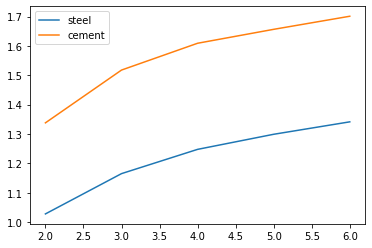

In [8]:
for source, klds in final_kl_divergence.items():
    plt.plot(perplexities, cao_and_wangs_criterion(perplexities, klds, n_instances[source]), label=source)
plt.legend()

Visualise based on a tSNE perplexity value of 2:

In [17]:
tsne_embedded_images = {source: read_results(source, 2)[0] for source in image_source_dir.keys()}

Apply DBSCAN for clustering, setting the clustering radius to 0.05

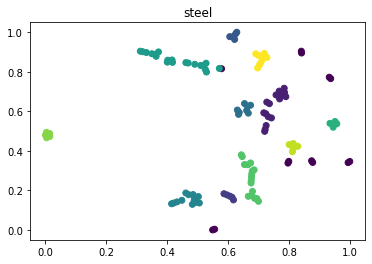

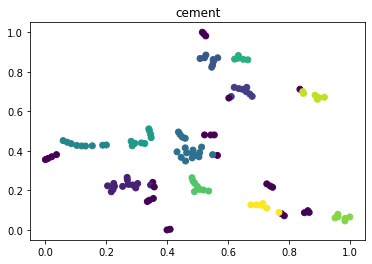

In [18]:
def cluster_tsne_embedded_images(tsne_embedded_images, source, eps=0.05):    
    filenames, points = zip(*tsne_embedded_images[source].items())
    points = np.array(list(points))
    clusters = sklearn.cluster.DBSCAN(eps=eps).fit_predict(points)
    
    plt.scatter(*points.T, c=clusters)
    plt.title(source)
    plt.show()
    
    clustered_images = defaultdict(list)
    for c, f in zip(clusters, filenames):
        clustered_images[c].append(f)
        
    return clustered_images

clustered_images = {}
for source in image_source_dir.keys():
    clustered_images[source] = cluster_tsne_embedded_images(tsne_embedded_images, source)

In [19]:
for source, clustering in clustered_images.items():
    print('Found {} clusters for source {}'.format(len(clustering), source))

Found 12 clusters for source steel
Found 12 clusters for source cement


Plot images by cluster

In [20]:
def plot_images(images, title, n_cols=8, figwidth=15, rowheight=2):
    n_rows = np.ceil(len(images) / n_cols)
    
    plt.figure(figsize=(figwidth, rowheight * n_rows))
    
    for i, f in enumerate(images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(plt.imread(f))
        plt.axis('off')
    
    plt.suptitle(title)

def plot_clusters(clustered_images, source):
    for cluster, images in clustered_images[source].items():
        plot_images(images, title='Cluster {}'.format(cluster))

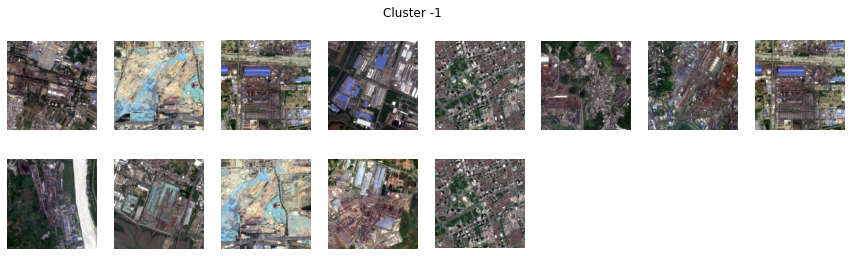

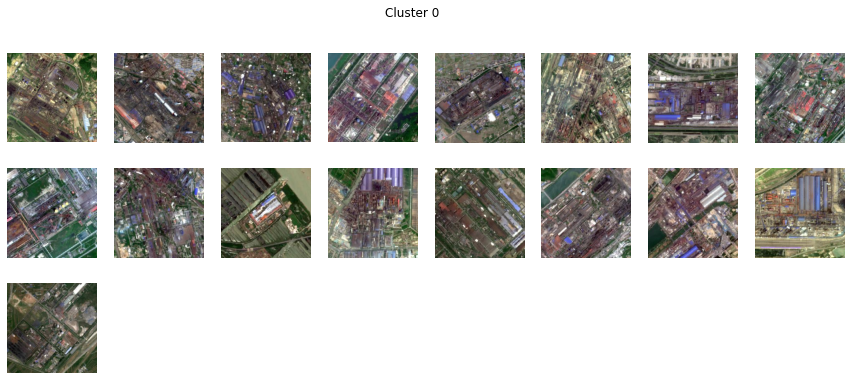

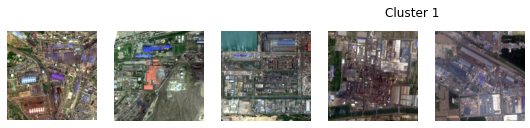

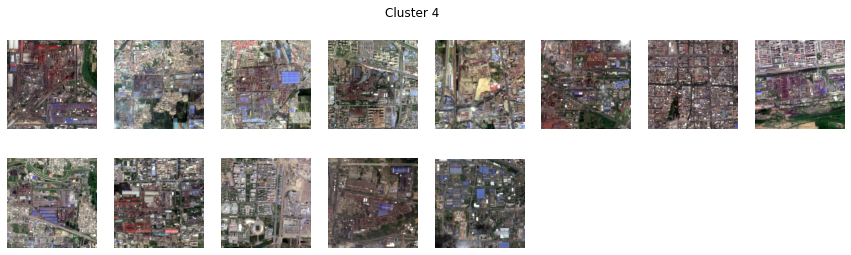

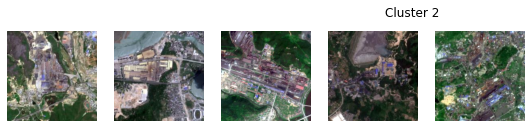

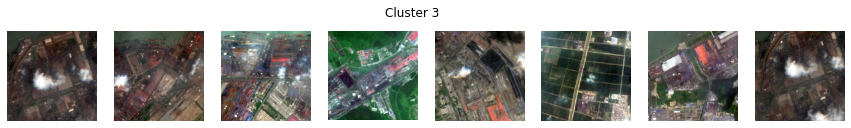

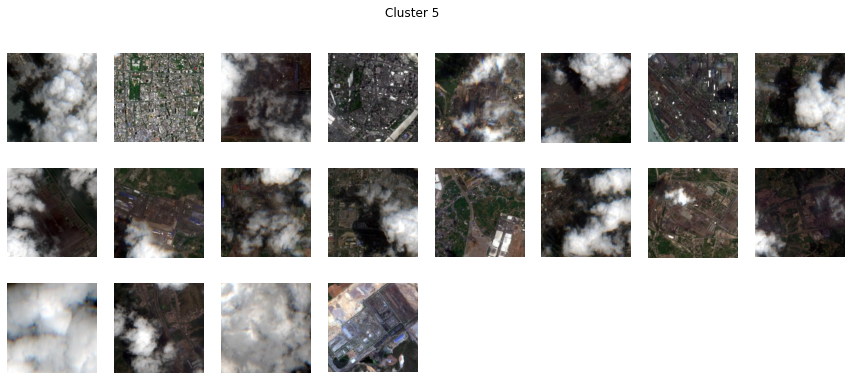

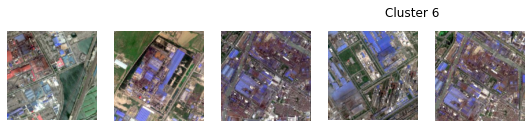

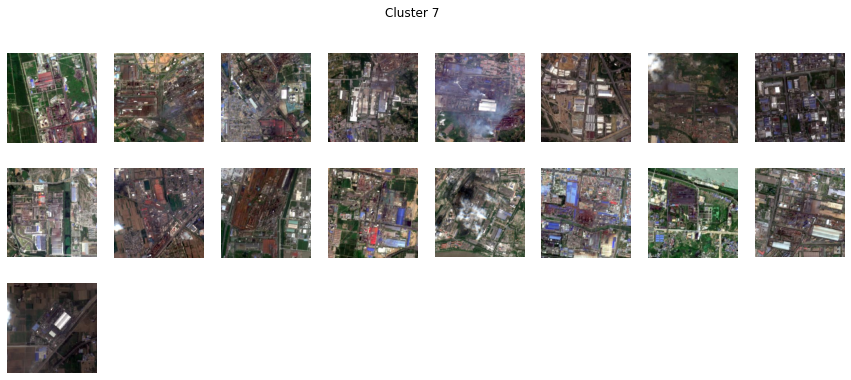

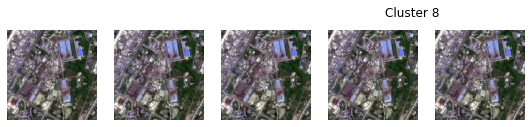

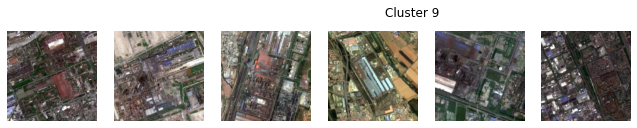

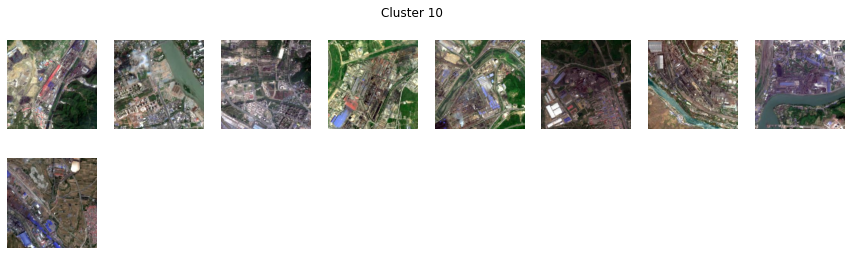

In [21]:
plot_clusters(clustered_images, 'steel')

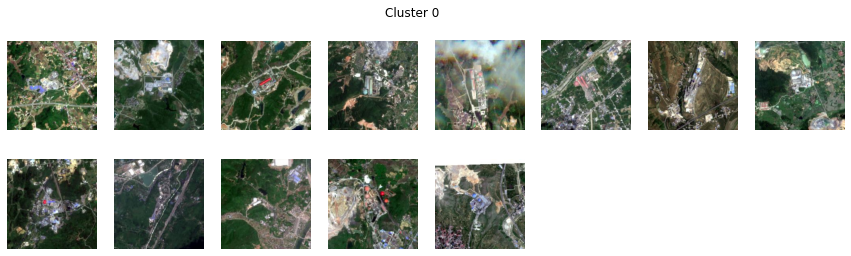

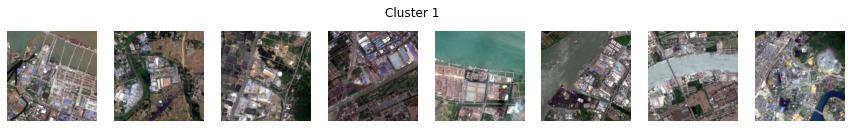

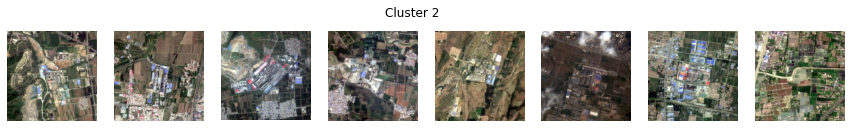

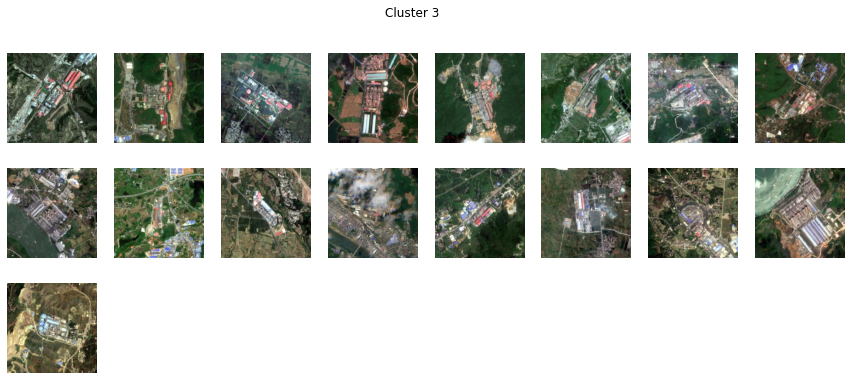

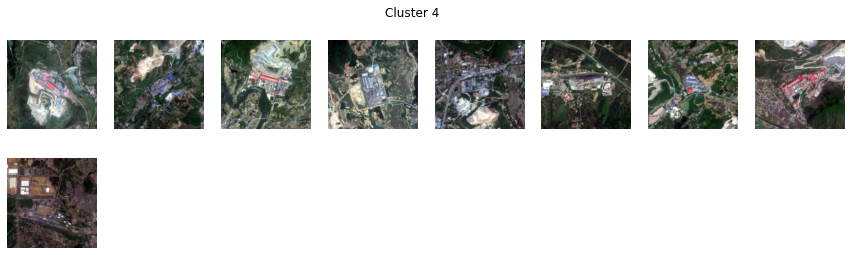

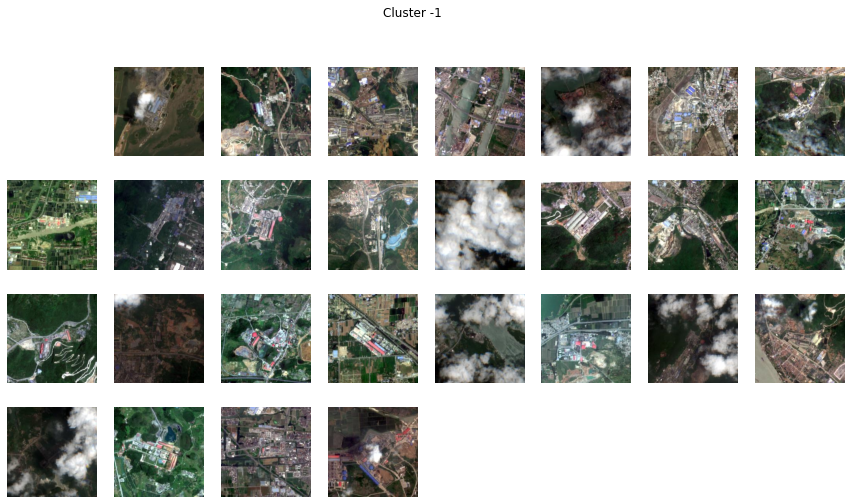

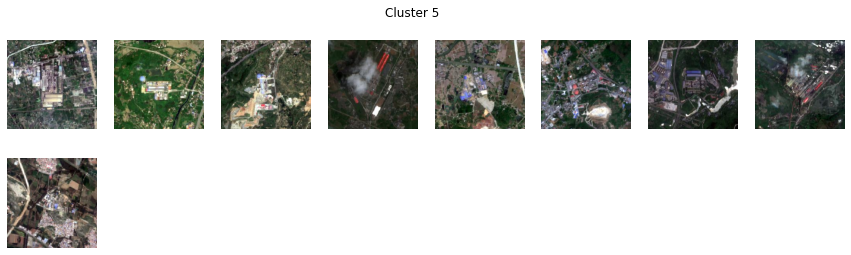

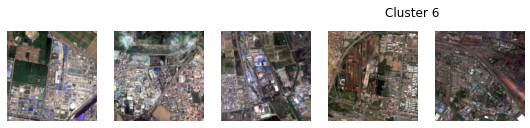

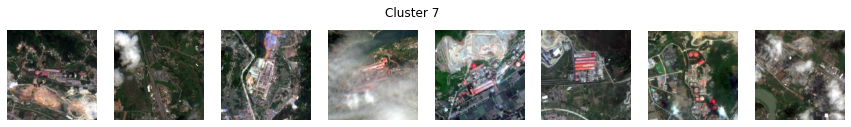

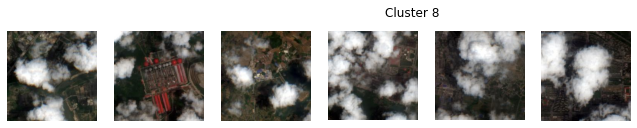

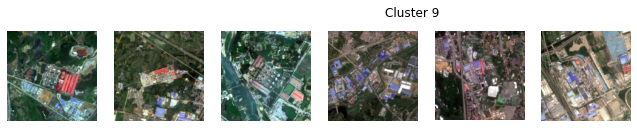

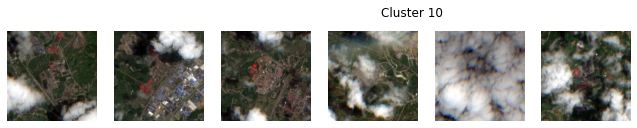

In [22]:
plot_clusters(clustered_images, 'cement')

In [24]:
def copy_to_filesystem_tree_by_cluster(clustered_images, target_dir='/scratch/clustered_images'):
    for source, clustering in clustered_images.items():
        for cluster, images in clustering.items():
            !mkdir -p {target_dir}/{source}/{cluster}
            for image in images:
                !cp {image} {target_dir}/{source}/{cluster}
            
    
copy_to_filesystem_tree_by_cluster(clustered_images)